## Client data

### Read in the dataset

In [216]:
import csv
import requests
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [217]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [218]:
#Upload dataset into colab first. Read it in.
with open('/content/gdrive/My Drive/Colab Notebooks/Orbisk_assg/data.csv', 'rb') as f:
  df = pd.read_csv(f)
df.head(2)


,date,total_weight
0,2019-07-14,18857
1,2019-07-15,44360


In [219]:
#convert to datetime object and index
# import datetime as dt
client_data_dt_id = df.copy() #If this is not done, causes errors while setting index multiple times
client_data_dt_id.dtypes #Check initial datatype

client_data_dt_id['date'] = pd.to_datetime(client_data_dt_id['date'])
client_data_dt_id['date'][0] #check the value
client_data_dt_id['date'][0].year #test if parsed correctly. try with month, and day as well
client_data_dt_id['date'] = client_data_dt_id['date'].apply(lambda x : x.date()) #strip time from the datetime object
print(client_data_dt_id['date'][0]) #to check if the format is correct

client_data_dt_id.set_index('date', drop = True, inplace=True)
client_data_dt_id
# client_data.dtypes

2019-07-14


,total_weight
date,
2019-07-14,18857
2019-07-15,44360
2019-07-17,104379
2019-07-18,84551
2019-07-19,47418
...,...
2021-07-23,32223
2021-07-24,61658
2021-07-25,42512


In [220]:
client_data_dt_id.describe()

,total_weight
count,592.000000
mean,31260.420608
std,28708.457952
min,0.000000
25%,7434.250000
50%,22715.500000
75%,50472.750000
max,151056.000000


Each row in the dataframe represents a day


### Visualise the data

In [221]:
#Create new cols for year, month, and day of week- time series resolution
# client_data.reset_index(inplace=True)
client_data_ts_res=df.copy()
client_data_ts_res['date'] = pd.to_datetime(client_data_ts_res['date'])
client_data_ts_res['year'] = client_data_ts_res['date'].apply(lambda x: x.year) #create year
client_data_ts_res['month'] = client_data_ts_res['date'].apply(lambda x: x.strftime("%b")) #month name
client_data_ts_res['day'] = client_data_ts_res['date'].apply(lambda x: x.strftime("%a")) #day name

client_data_ts_res.head()

,date,total_weight,year,month,day
0,2019-07-14,18857,2019,Jul,Sun
1,2019-07-15,44360,2019,Jul,Mon
2,2019-07-17,104379,2019,Jul,Wed
3,2019-07-18,84551,2019,Jul,Thu
4,2019-07-19,47418,2019,Jul,Fri


#### Yearly

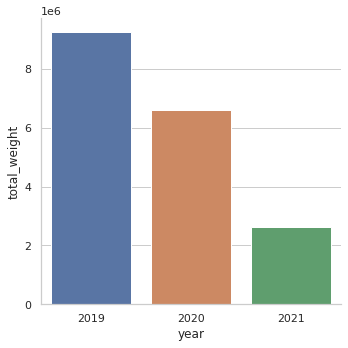

In [222]:
sns.set_theme(style="whitegrid")
sns.catplot(x='year', y='total_weight',data=client_data_ts_res, kind='bar',estimator=sum, ci= False)

In [223]:
# df_year= pd.DataFrame(client_data.groupby('year')['total_weight'].sum())
pd.DataFrame(client_data_ts_res.groupby('year')['total_weight'].sum())
# df_year

,total_weight
year,
2019,9266040
2020,6616061
2021,2624068


In [224]:
# sns.distplot(client_data['total_weight'], hist = True)

import plotly.express as px
ordered_months = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'] # June and May is reversed if no order. Follows actual count values desc
fig = px.histogram(client_data_ts_res, x="month", y="total_weight", color = 'year',
                   marginal="box", # or violin, rug
                  #  hover_data= ['total_weight'],
                   category_orders= dict(month=ordered_months)
                   )
fig.show()

Each year stack represents count proportions. So can compare size with each other.
  - These are the days for each data is available
  - Splits the year into quartiles.
  - Mostly indicative of when the restaurant was open.
    * 2019 has 6 months of data. Most months we have data points for all days (30-31 days). Except September (19 days).
    - 2020 has 10 months of data. Dips correspond to possible Covid closures. 
    - 2021 has lower average open days till April, followed by more open days from May onwards.

  

In [225]:
client_data_ts_res.groupby(['year','month']).sum()

total_weight
year month              
2019 Aug         2798826
     Dec         1457575
     Jul          299565
     Nov         1331386
     Oct         1994688
     Sep         1384000
2020 Apr               0
     Aug          815712
     Dec          128666
     Feb         1273772
     Jan         1313058
     Jul          715015
     Jun          183916
     Mar          777326
     Nov           62697
     Oct          437903
     Sep          907996
2021 Apr          149391
     Feb          120150
     Jan          107969
     Jul         1283167
     Jun          480442
     Mar          141898
     May          341051

In [226]:
ordered_months = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'] # June and May is reversed if no order. Follows actual count values desc
fig = px.histogram(client_data_ts_res, x="month", y="total_weight", color = 'year',
                   marginal="box", # or violin, rug
                  #  hover_data= ['total_weight'],
                   category_orders= dict(month=ordered_months),
                   histfunc = 'sum'
                   )
fig.show()

* The box plot at the top speaks about the count of values. 
* Food waste for July 2021 indicates an upward trend in food waste.
* It is difficult to compare the differnt years because COVID has made the consumption volatile.

In [227]:
# Number of 0 values and missing values
import numpy as np
import missingno as msno
len(client_data_ts_res[client_data_ts_res['total_weight']==0]) # 17 values which are 0
# client_data_ts_res[client_data_ts_res['total_weight']==0]
# msno.matrix(client_data_ts_res) #No missing values

17

#### Trend - Total and Monthly

In [228]:
#--------basic line plot
# fig, ax = plt.subplots(figsize=(16,6))
# client_data['total_weight'].plot(style = 'k')
# plt.xticks(rotation = 70)
# plt.show()

#---------plotly line plot

import plotly.express as px
fig = px.scatter(client_data_ts_res, x="date", y= 'total_weight',
              # hover_data={"date": ",
              # title='custom tick labels',
              ).update_traces(mode='lines+markers')
fig.update_xaxes(
    dtick="M1",
    tickformat="%b\n%Y",
    # tickformat="%b\n%a"
    )
fig.show()

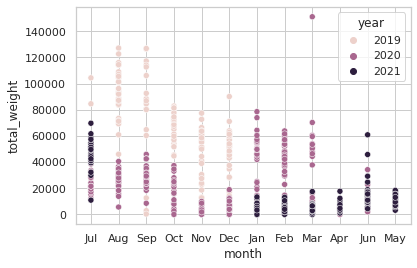

In [229]:
#groupby month and plot
df_monthly=pd.DataFrame(client_data_ts_res.groupby(['year','month'])['total_weight'].sum())
df_monthly.reset_index(inplace= True)

# ordered_months = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
# sns.catplot(x='month', y='total_weight',data=df_monthly, kind='bar',estimator=sum, ci= False)
sns.scatterplot(x='month', y='total_weight',hue='year',data=client_data_ts_res)

/usr/local/lib/python3.7/dist-packages/seaborn/axisgrid.py:670: UserWarning:

Using the barplot function without specifying `order` is likely to produce an incorrect plot.



<Figure size 1440x720 with 0 Axes>

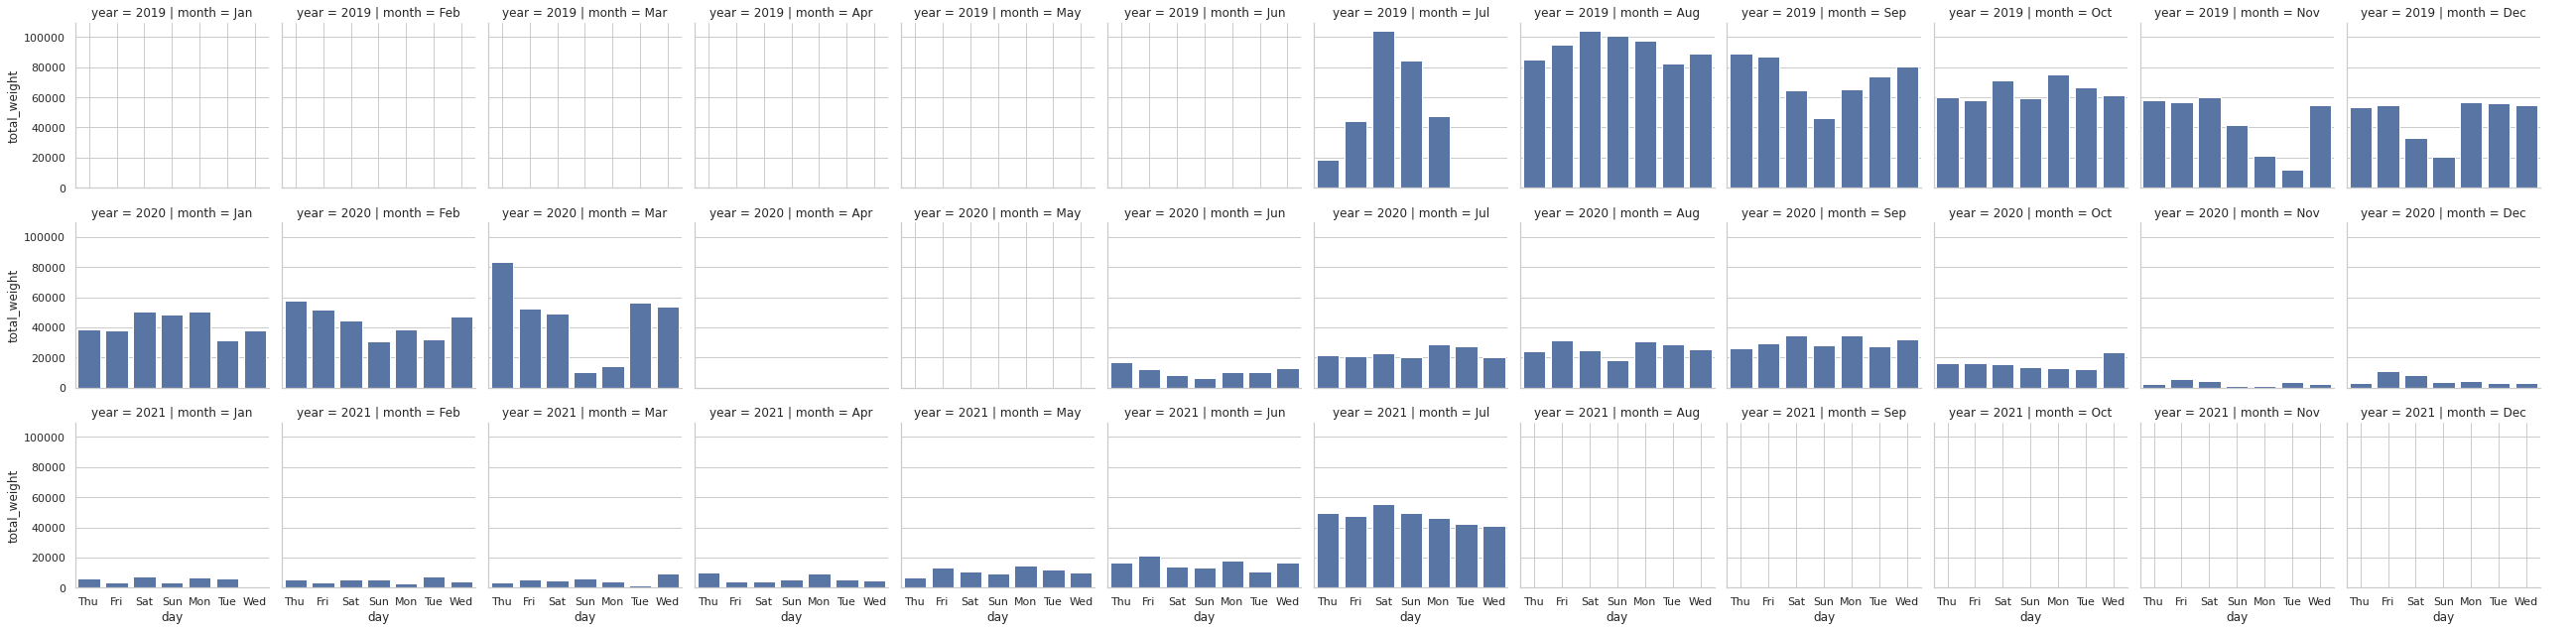

In [230]:
plt.figure(figsize=(20,10))
ordered_days = ['Mon','Tue','Wed','Thu','Fri','Sat','Sun']
ordered_months = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
g = sns.FacetGrid(client_data_ts_res, row="year", col='month', col_order= ordered_months)
g.map(sns.barplot, "day", "total_weight",ci = False)
g.add_legend()

/usr/local/lib/python3.7/dist-packages/seaborn/axisgrid.py:670: UserWarning:

Using the boxplot function without specifying `order` is likely to produce an incorrect plot.



<Figure size 1440x720 with 0 Axes>

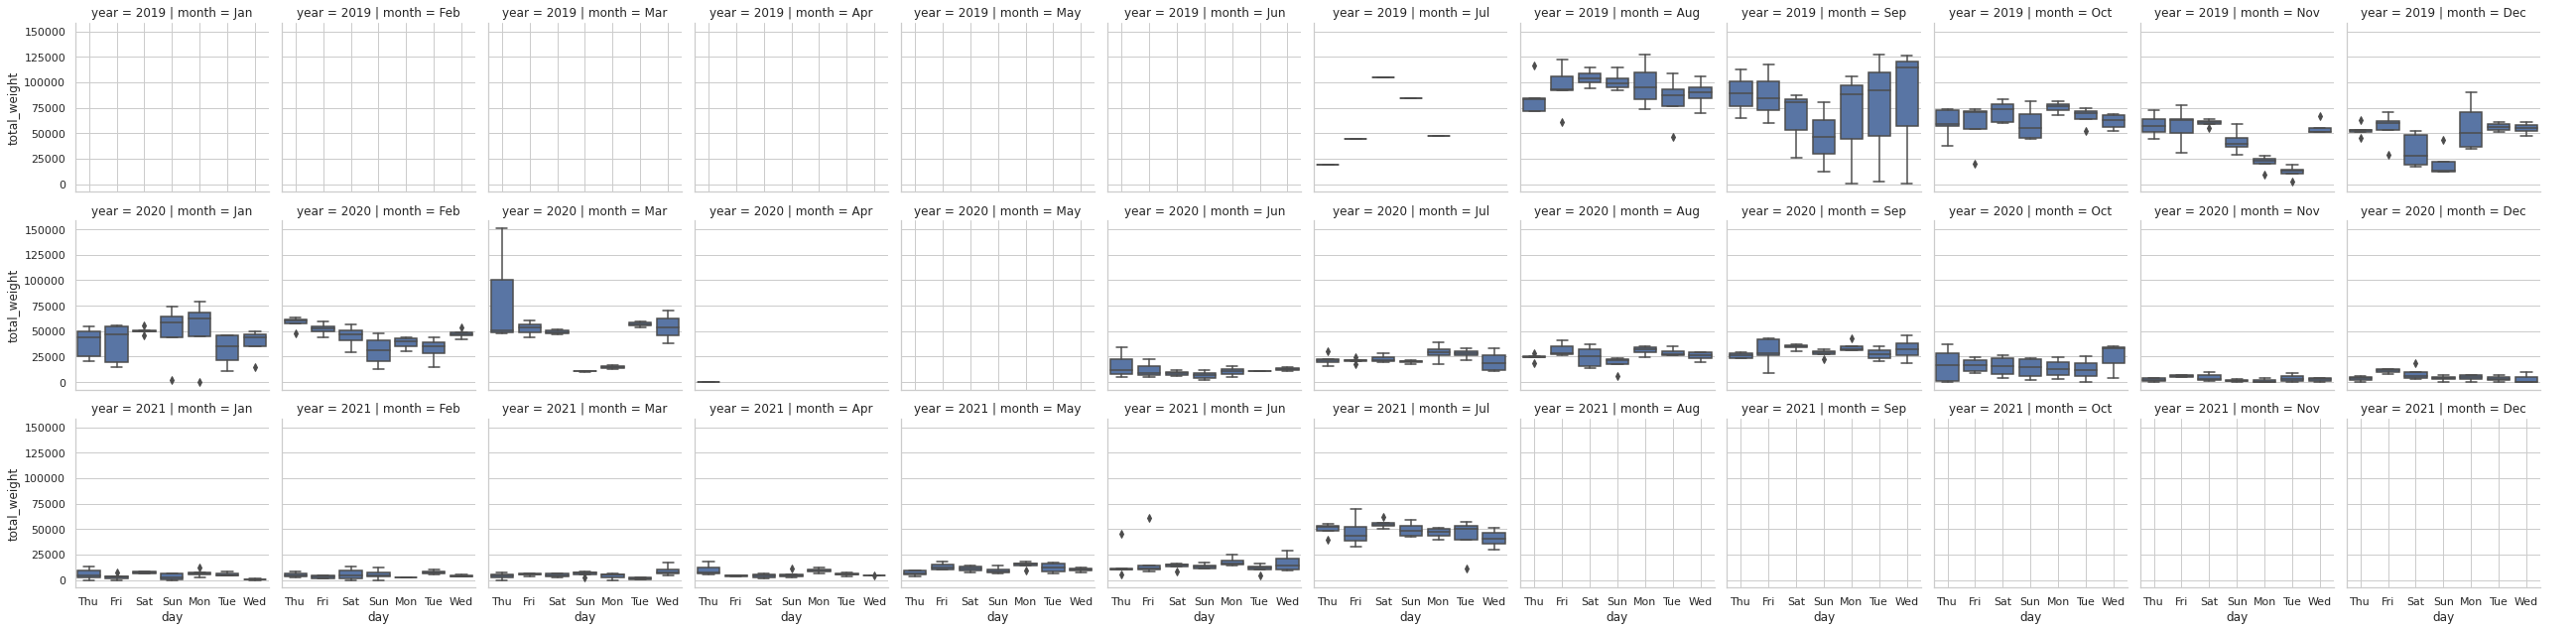

In [231]:
plt.figure(figsize=(20,10))
ordered_days = ['Mon','Tue','Wed','Thu','Fri','Sat','Sun']
ordered_months = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
g = sns.FacetGrid(client_data_ts_res, row="year", col='month', col_order= ordered_months)
g.map(sns.boxplot, "day", "total_weight")
g.add_legend()

/usr/local/lib/python3.7/dist-packages/seaborn/axisgrid.py:670: UserWarning:

Using the boxplot function without specifying `order` is likely to produce an incorrect plot.



<Figure size 1440x1440 with 0 Axes>

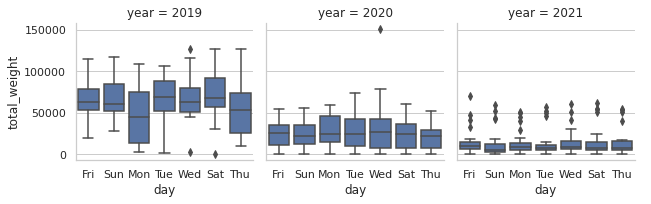

In [232]:
plt.figure(figsize=(20,20))
ordered_days = ['Mon','Tue','Wed','Thu','Fri','Sat','Sun']
ordered_months = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
g = sns.FacetGrid(client_data_ts_res, col="year")
g.map(sns.boxplot, "day", "total_weight")
g.add_legend()

* 2019 Lows are Mondays and Thursdays 
* 2020 Lows are Thursdays and  Sun/Mon
* 2021 Lows are Thur, Sun, Tue

Some kind of strategy implemented operationally? 

#### Additional representations

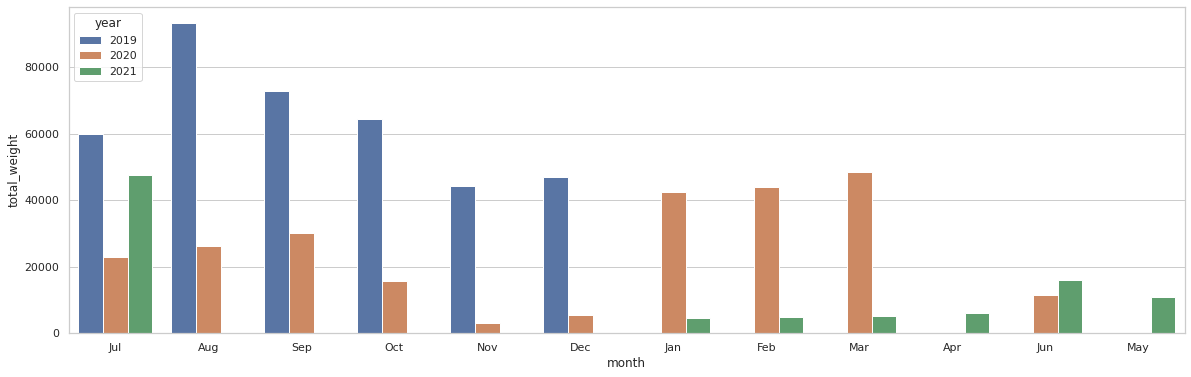

In [233]:
#month with a hue of year
sns.set_theme(style="whitegrid")

fig, ax = plt.subplots(figsize=(20, 6))
ax = sns.barplot(x="month", y="total_weight", hue="year", data=client_data_ts_res, ci = False)



Data has been collected from July 2019 to July 2021.
  - In 2020 data is missing for April and May. 

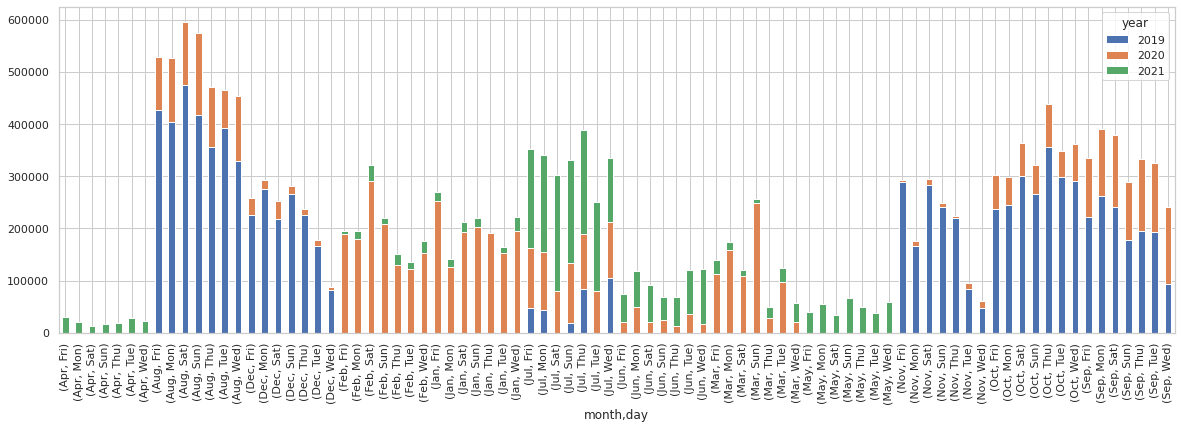

In [234]:
# fig, ax = plt.subplots(figsize=(20,6))
# plt.figure(figsize=(20,6))

#Bar 1 - total monthly 
year_stack = client_data_ts_res.groupby(['month', 'day','year'])['total_weight'].sum().unstack().fillna(0) 


#Bar 2 - stack of the years

year_stack.plot(kind='bar', stacked=True, figsize=(20,6))
plt.show()
# fig, ax = plt.subplots(figsize=(20, 6))
# ax = sns.barplot(x="month", y="total_weight", hue="day", data=client_data, ci = False)

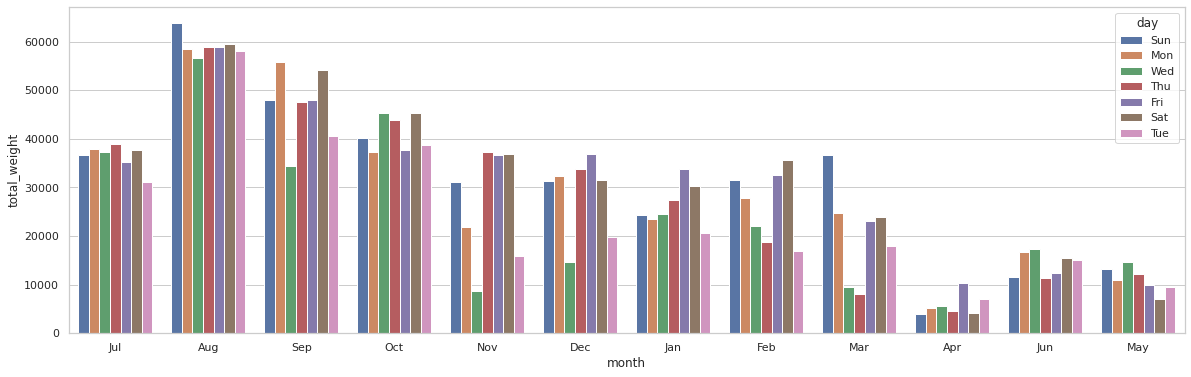

In [235]:
#Stack year as hue otherwise not too indicative


fig, ax = plt.subplots(figsize=(20, 6))
ax = sns.barplot(x="month", y="total_weight", hue="day", data=client_data_ts_res, ci = False)

## Weather data

### Read and save dataset for full range of client_data

In [236]:
# Retrieve weather data and download to drive
# ## Set custom start, end date, and weather station number 
# ##   for KNMI API request: 'YYYYMMDD'
# start_date = '20190701'  #'20210101' # 1st Jan
# end_date = '20210731'             #'202107'# to 1st March
# weather_station_number = 'ALL'

# # Documentation of KNMI api requests can be found here: https://www.knmi.nl/kennis-en-datacentrum/achtergrond/data-ophalen-vanuit-een-script
# weather_data_remote_path = 'https://www.daggegevens.knmi.nl/klimatologie/daggegevens'

# weather_data_params = {
#     'start': start_date,
#     'end': end_date,
#     'stns': weather_station_number,
#     'fmt': 'json'
# }

# # Perform the API request
# response = requests.get(weather_data_remote_path, params=weather_data_params)
# weather_data = pd.DataFrame(response.json())

# #save to file
# weather_data.to_csv('weather_data.csv',index_label=False)
# !cp weather_data.csv "/content/gdrive/My Drive/Colab Notebooks/Orbisk_assg/" #copy the file to drive location



In [237]:
#----------read in the weather data from drive----------
with open('/content/gdrive/My Drive/Colab Notebooks/Orbisk_assg/weather_data.csv', 'rb') as f:
  weather_data = pd.read_csv(f)
# weather_data=pd.read_csv('weather_data.csv', ) 
weather_data.head()

,station_code,date,DDVEC,FHVEC,FG,FHX,FHXH,FHN,FHNH,FXX,FXXH,TG,TN,TNH,TX,TXH,T10N,T10NH,SQ,SP,Q,DR,RH,RHX,RHXH,PG,PX,PXH,PN,PNH,VVN,VVNH,VVX,VVXH,NG,UG,UX,UXH,UN,UNH,EV24
0,209,2019-07-01T00:00:00.000Z,279.0,73.0,74.0,90.0,1.0,60.0,17.0,110.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,209,2019-07-02T00:00:00.000Z,354.0,49.0,52.0,70.0,3.0,30.0,9.0,80.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,209,2019-07-03T00:00:00.000Z,16.0,59.0,62.0,70.0,8.0,50.0,1.0,100.0,15.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,209,2019-07-04T00:00:00.000Z,290.0,28.0,39.0,70.0,23.0,20.0,3.0,100.0,24.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,209,2019-07-05T00:00:00.000Z,298.0,42.0,46.0,80.0,1.0,20.0,21.0,100.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


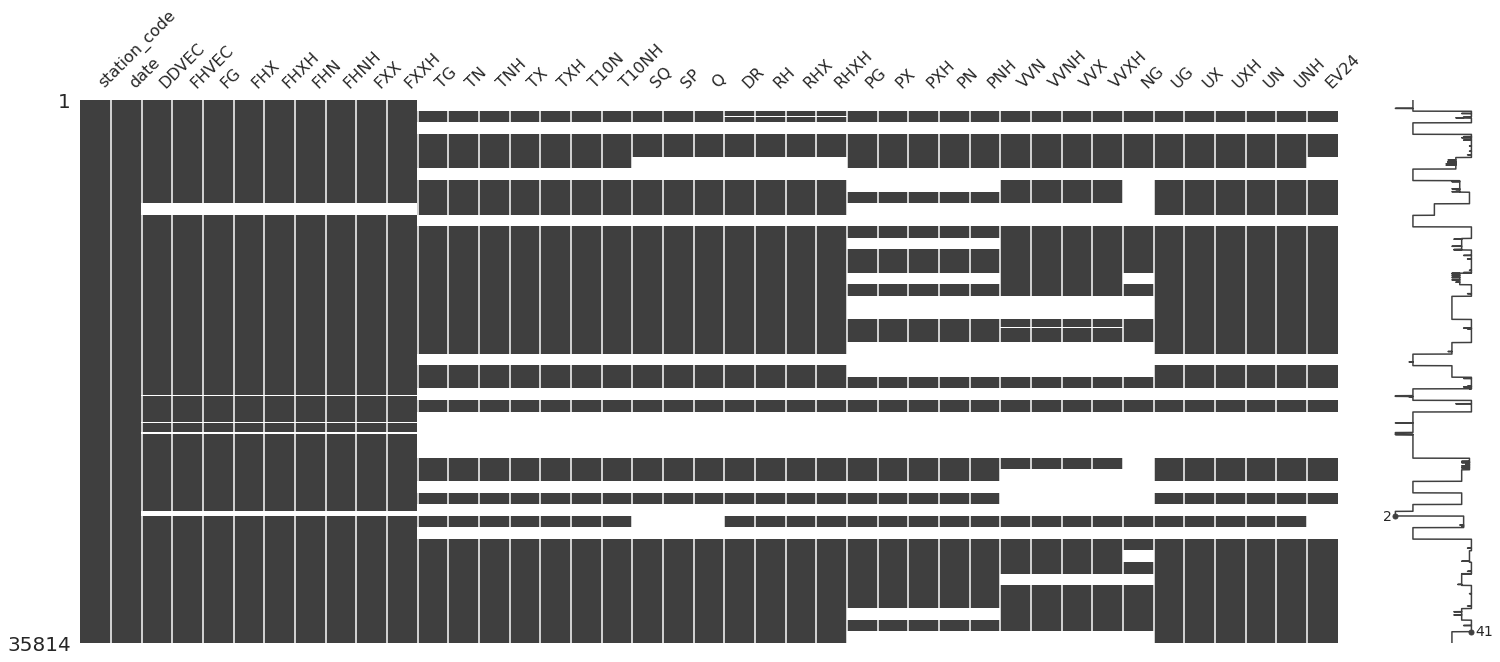

In [238]:
import missingno as msno
msno.matrix(weather_data) 


In [239]:
#test uniqueness of each row
we_gp_date=weather_data.groupby('date').agg({ 'station_code' : 'count'}).head()
we_gp_date['station_code'].mean() #47 stations per day.

47.0

In [240]:
#Are all the stations similar in values for a given day? 
we_dt_st=weather_data.groupby(['date','station_code']).sum()
we_dt_st.iloc[0:2][:20] #Check values for a particular day.  

def multindex_iloc(df, index):
    label = df.index.levels[0][index]
    return df.iloc[df.index.get_loc(label)]

multindex_iloc(we_dt_st, 5)[:10] #check specific days to see if values can be averaged for diff stations

DDVEC  FHVEC    FG  ...    UN   UNH  EV24
date                     station_code                      ...                  
2019-07-06T00:00:00.000Z 209           311.0   47.0  64.0  ...   0.0   0.0   0.0
                         215           304.0   27.0  35.0  ...  77.0   8.0  25.0
                         225           302.0   49.0  66.0  ...   0.0   0.0   0.0
                         235           295.0   39.0  46.0  ...  61.0  23.0  19.0
                         240           296.0   31.0  40.0  ...  66.0   9.0  25.0
                         242           300.0   69.0  82.0  ...  58.0  21.0   0.0
                         248           284.0   31.0  38.0  ...   0.0   0.0   0.0
                         249           290.0   33.0  40.0  ...  72.0   9.0  17.0
                         251           295.0   57.0  65.0  ...  62.0  15.0  21.0
                         257             0.0    0.0   0.0  ...  64.0  23.0  19.0

[10 rows x 39 columns]

Each row represents data for a particular station on a particular day.
There are 47 stations per day.

#### Take mean values of stations for each day

In [241]:
# Let us take mean of the station values for a particular day. Before mean weather data has missing vals.
we_dt_mean=weather_data.groupby('date').mean() 
we_dt_mean = we_dt_mean.drop('station_code', 1) #drop station code which has no meaning now
we_dt_mean.reset_index(inplace=True)
we_dt_mean.head()

,date,DDVEC,FHVEC,FG,FHX,FHXH,FHN,FHNH,FXX,FXXH,TG,TN,TNH,TX,TXH,T10N,T10NH,SQ,SP,Q,DR,RH,RHX,RHXH,PG,PX,PXH,PN,PNH,VVN,VVNH,VVX,VVXH,NG,UG,UX,UXH,UN,UNH,EV24
0,2019-07-01T00:00:00.000Z,272.000000,53.043478,56.391304,77.608696,9.021739,29.565217,11.760870,121.086957,10.391304,178.176471,135.000000,15.588235,219.323529,12.441176,114.294118,16.058824,111.50000,66.87500,2405.06250,0.000000,-0.030303,-0.030303,1.000000,10183.083333,10214.916667,23.291667,10155.875000,2.416667,59.000000,3.280000,82.080000,15.240000,4.300000,70.058824,92.264706,3.117647,52.500000,13.235294,42.15625
1,2019-07-02T00:00:00.000Z,292.630435,38.391304,42.500000,63.913043,12.434783,20.434783,10.543478,97.608696,12.478261,166.558824,111.352941,18.470588,213.823529,13.735294,83.852941,19.764706,120.90625,72.34375,2548.56250,0.454545,0.878788,0.818182,1.181818,10234.000000,10246.083333,23.083333,10213.500000,2.083333,64.080000,9.800000,82.360000,12.280000,3.157895,66.411765,89.794118,12.088235,46.235294,12.794118,43.56250
2,2019-07-03T00:00:00.000Z,147.891304,43.521739,45.500000,67.391304,13.043478,20.869565,5.152174,105.652174,13.304348,151.470588,94.882353,13.647059,202.264706,13.411765,66.000000,14.470588,106.90625,64.06250,2360.21875,0.090909,-0.030303,-0.030303,1.090909,10259.833333,10268.791667,19.583333,10246.166667,2.166667,56.480000,3.200000,82.320000,13.440000,3.052632,65.735294,90.617647,3.470588,45.823529,13.000000,39.09375
3,2019-07-04T00:00:00.000Z,193.956522,24.282609,31.434783,53.043478,13.630435,9.782609,7.847826,83.478261,13.934783,162.441176,77.117647,3.529412,218.852941,14.705882,49.911765,6.000000,132.81250,79.84375,2753.28125,0.000000,-0.030303,-0.030303,1.000000,10236.666667,10266.666667,1.333333,10193.375000,23.958333,62.280000,3.440000,82.280000,14.720000,5.850000,66.235294,91.882353,4.147059,47.617647,13.382353,46.71875
4,2019-07-05T00:00:00.000Z,289.260870,32.782609,37.369565,59.347826,8.065217,14.130435,16.239130,94.130435,9.847826,180.794118,126.147059,21.823529,228.617647,13.470588,104.058824,23.470588,92.93750,56.00000,2414.93750,0.000000,-0.060606,-0.060606,1.000000,10172.291667,10190.666667,1.375000,10141.500000,24.000000,62.458333,13.208333,81.708333,14.083333,5.350000,69.147059,90.941176,20.264706,51.500000,13.294118,42.62500


### Prepare to join tables

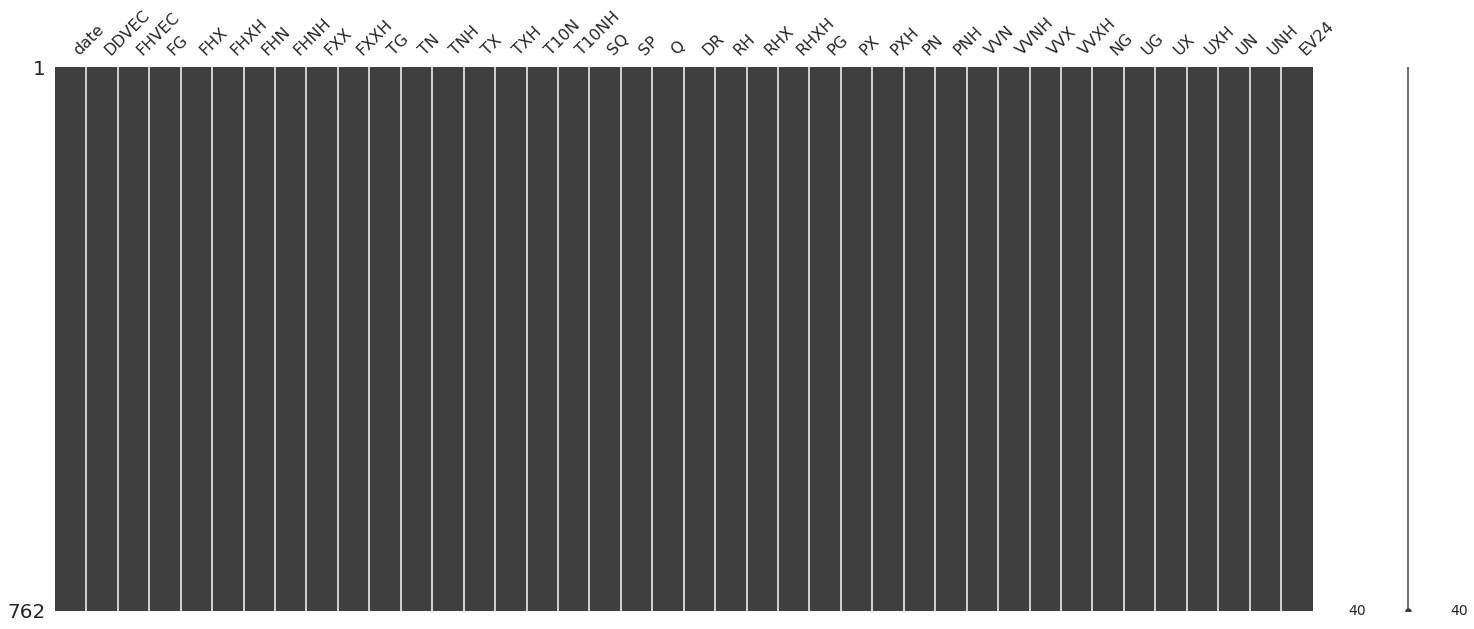

In [242]:
#Visualise missing data by days
# import missingno as msno
msno.matrix(we_dt_mean) 

Missing values of station or date handled by averages.
No missing values and 762 days

In [243]:
#Check corelations for all. Which is highest?
we_dt_mean.describe()

,DDVEC,FHVEC,FG,FHX,FHXH,FHN,FHNH,FXX,FXXH,TG,TN,TNH,TX,TXH,T10N,T10NH,SQ,SP,Q,DR,RH,RHX,RHXH,PG,PX,PXH,PN,PNH,VVN,VVNH,VVX,VVXH,NG,UG,UX,UXH,UN,UNH,EV24
count,762.000000,762.000000,762.000000,762.000000,762.000000,762.000000,762.000000,762.000000,762.000000,762.000000,762.000000,762.000000,762.000000,762.000000,762.000000,762.000000,762.000000,762.000000,762.000000,762.000000,762.000000,762.000000,762.000000,762.000000,762.000000,762.000000,762.000000,762.000000,762.000000,762.000000,762.000000,762.000000,762.000000,762.000000,762.000000,762.000000,762.000000,762.000000,762.000000
mean,192.694787,44.310894,50.350028,74.691072,11.194901,26.302948,9.586348,117.443249,12.028156,112.941524,71.371507,11.047360,152.160769,13.576245,56.855016,13.401712,53.871359,40.873628,1130.348763,17.661754,22.455381,8.974337,6.975082,10146.517170,10176.944335,12.350612,10114.248524,12.062609,43.794697,9.955284,76.725668,12.022888,5.977795,79.775012,93.799192,9.515137,63.612606,13.251475,18.139776
std,75.521293,22.047243,20.673953,25.265907,4.228045,16.637763,5.709980,39.711591,4.226819,59.668244,53.838249,6.713348,70.104581,2.849916,54.331362,6.102488,41.298195,27.937719,817.621731,24.580845,32.592423,12.103370,5.751907,103.831804,97.838144,8.957492,111.902712,8.847102,16.532662,4.728586,5.902843,3.152972,2.026417,10.147239,5.128525,5.243312,14.979519,2.504953,14.402036
min,20.869565,7.022727,14.931818,28.181818,1.021739,3.260870,1.065217,47.500000,1.173913,-54.382353,-104.970588,1.029412,-34.000000,1.029412,-124.714286,6.000000,0.000000,0.000000,45.593750,0.000000,-0.424242,-0.454545,1.000000,9773.166667,9798.791667,1.000000,9724.583333,1.000000,0.920000,2.160000,41.960000,1.000000,0.000000,44.264706,59.970588,1.352941,25.205882,1.558824,0.750000
25%,145.451812,28.059783,35.331522,55.869565,8.387599,13.352273,4.483696,87.625126,9.379447,65.529412,29.977941,5.095588,95.654412,12.823529,14.588235,7.588235,18.257812,17.500000,347.289062,0.218750,0.000000,0.000000,1.250000,10084.979167,10117.177083,2.072917,10050.645833,2.666667,32.720000,6.280000,73.716033,10.600000,5.050000,73.705882,92.272059,5.000000,52.867647,12.441176,4.796875
50%,208.803854,41.000000,46.670048,70.652174,11.141304,22.667984,8.633399,111.521739,11.891304,110.544118,70.044118,9.323529,148.338235,13.764706,56.044118,11.823529,46.812500,37.453125,983.734375,6.738636,6.585227,3.909091,5.666667,10154.000000,10185.312500,11.416667,10122.020833,12.145833,46.325833,9.140000,78.162500,12.480000,6.600000,81.294118,95.294118,8.573529,65.000000,13.529412,14.437500
75%,245.467391,56.857955,61.219121,88.992095,13.928261,35.163043,14.438735,139.728261,14.622222,161.227941,113.345588,17.139706,207.338235,14.529412,99.558824,18.838235,83.492188,64.062500,1803.296875,24.310606,33.511364,14.234848,11.287879,10217.572917,10240.822917,22.166667,10193.177083,21.156250,57.160000,13.353333,81.272500,14.070417,7.550000,87.286765,96.970588,13.375000,75.786765,14.433824,28.718750
max,340.266667,132.000000,138.000000,182.608696,22.565217,113.695652,23.217391,283.913043,22.733333,285.735294,205.676471,23.852941,373.647059,23.941176,194.264706,24.000000,153.250000,93.281250,3003.750000,143.818182,200.818182,85.909091,22.878788,10465.000000,10479.833333,24.000000,10443.708333,24.000000,79.080000,22.791667,83.160000,20.840000,8.000000,97.676471,99.294118,23.000000,94.088235,22.000000,55.937500


60 values. for each day.

In [244]:
# # Create datetime object 
# weather_data_dt = weather_data.copy() #Copy before alterations
# weather_data_dt.dtypes #Check initial datatype
# weather_data_dt['date'] = pd.to_datetime(weather_data_dt['date'])
# weather_data_dt['date'][0] #check the value
# weather_data_dt['date'][0].year #test if parsed correctly. try with month, and day as well


# weather_data_dt['date'] = weather_data_dt['date'].apply(lambda x : x.date()) #strip time from the datetime object
# print(weather_data_dt['date'][0]) #to check if the format is correct
# weather_data_dt['date'] = pd.to_datetime(weather_data_dt['date']) #Convert again to datetime object



# we_dt_mean = we_dt_mean.copy() #Copy before alterations
we_dt_mean.dtypes #Check initial datatype
we_dt_mean['date'] = pd.to_datetime(we_dt_mean['date'])
we_dt_mean['date'][0] #check the value
we_dt_mean['date'][0].year #test if parsed correctly. try with month, and day as well


we_dt_mean['date'] = we_dt_mean['date'].apply(lambda x : x.date()) #strip time from the datetime object
print(we_dt_mean['date'][0]) #to check if the format is correct
we_dt_mean['date'] = pd.to_datetime(we_dt_mean['date']) #Convert again to datetime object
we_dt_mean.dtypes[0:2] #datetime object created


2019-07-01


date     datetime64[ns]
DDVEC           float64
dtype: object

### Join full range of customer data - view correlations

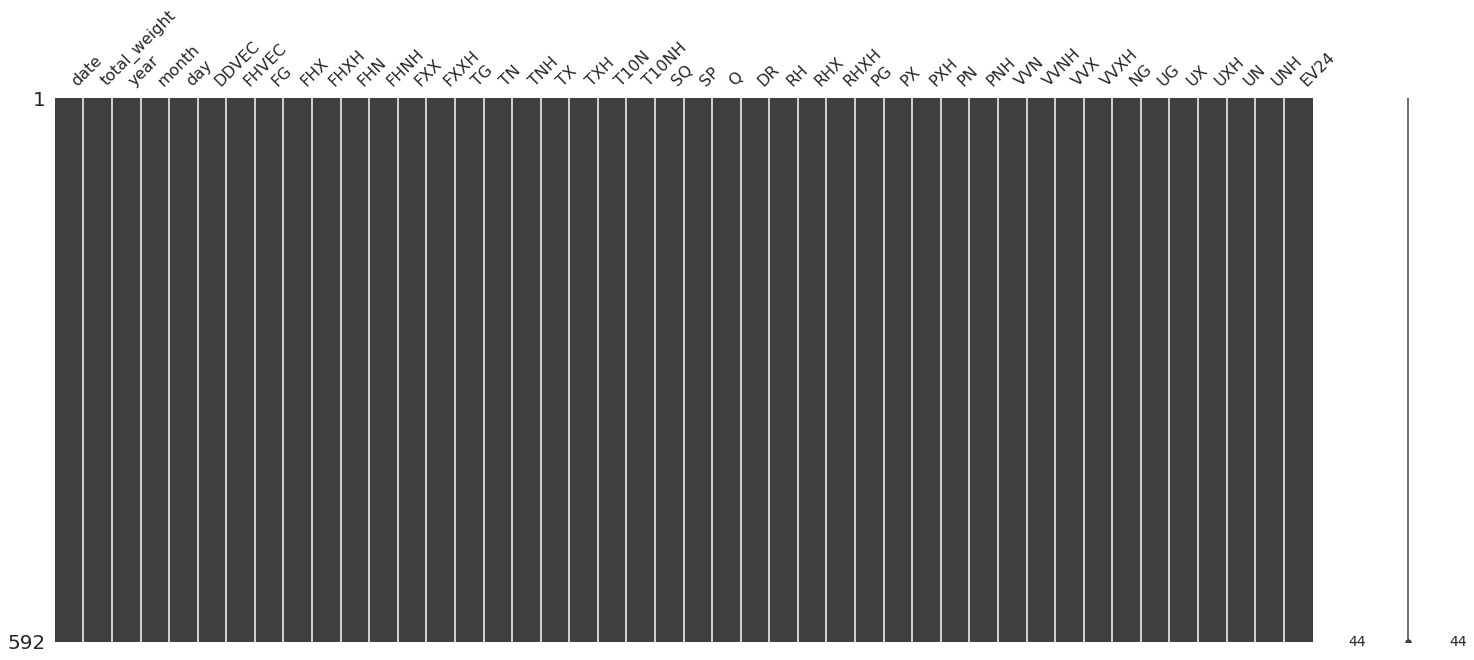

In [245]:
#join tables (client_date and weather_df)
# len(we_dt_mean) #60 rows
# len(client_data_ts_res) #592 rows
# client_data_ts_res.dtypes
# we_dt_mean.dtypes

cl_wea_df = pd.merge(client_data_ts_res, we_dt_mean, on='date',how='left')  #include all rows of the left
cl_wea_df
msno.matrix(cl_wea_df) #Date range was only 2 months.
# weather_data_dt

We can define date range for how much data we want to join. Scope changed to full scope of the data.

In [246]:
cl_wea_df.head()

,date,total_weight,year,month,day,DDVEC,FHVEC,FG,FHX,FHXH,FHN,FHNH,FXX,FXXH,TG,TN,TNH,TX,TXH,T10N,T10NH,SQ,SP,Q,DR,RH,RHX,RHXH,PG,PX,PXH,PN,PNH,VVN,VVNH,VVX,VVXH,NG,UG,UX,UXH,UN,UNH,EV24
0,2019-07-14,18857,2019,Jul,Sun,279.086957,44.847826,46.108696,65.652174,12.304348,28.043478,10.086957,102.391304,10.739130,153.117647,125.088235,9.941176,184.647059,13.882353,118.117647,11.823529,21.37500,13.00000,1273.25000,4.363636,2.909091,1.515152,4.575758,10207.458333,10212.208333,15.166667,10200.833333,4.666667,56.12,6.48,80.04,12.56,7.65,77.588235,92.470588,8.617647,65.764706,14.852941,21.12500
1,2019-07-15,44360,2019,Jul,Mon,318.869565,35.326087,37.043478,55.000000,12.391304,20.652174,6.565217,86.304348,11.652174,149.294118,122.382353,6.735294,182.235294,14.264706,113.441176,9.000000,14.31250,8.78125,1153.84375,0.272727,-0.424242,-0.454545,1.424242,10204.333333,10210.083333,6.041667,10199.083333,15.541667,57.60,9.68,79.92,10.68,7.70,77.470588,90.529412,10.470588,63.235294,11.823529,19.00000
2,2019-07-17,104379,2019,Jul,Wed,92.239130,8.347826,18.217391,34.565217,16.673913,5.000000,4.152174,57.608696,15.434783,174.941176,101.411765,6.294118,237.500000,15.323529,78.235294,9.705882,91.78125,56.43750,2288.56250,0.000000,-0.030303,-0.030303,1.000000,10150.291667,10174.041667,1.166667,10123.916667,23.916667,28.36,7.92,81.32,15.36,5.75,74.941176,97.323529,6.500000,50.147059,14.558824,39.75000
3,2019-07-18,84551,2019,Jul,Thu,217.152174,37.326087,45.630435,70.217391,12.652174,24.130435,5.739130,112.608696,14.847826,189.558824,141.147059,8.735294,237.441176,11.617647,126.882353,11.294118,37.87500,23.37500,1672.75000,10.030303,19.575758,10.727273,12.636364,10110.625000,10123.750000,16.166667,10102.666667,8.833333,47.88,13.04,79.00,11.24,7.85,74.382353,93.147059,17.235294,53.205882,10.705882,29.90625
4,2019-07-19,47418,2019,Jul,Fri,222.804348,19.608696,28.456522,48.913043,9.847826,9.347826,11.326087,80.434783,11.478261,193.176471,137.647059,5.352941,243.647059,14.294118,120.882353,8.647059,62.28125,38.53125,1963.40625,0.363636,0.181818,0.030303,2.333333,10129.416667,10138.833333,9.458333,10112.333333,21.125000,37.24,5.84,81.88,15.04,7.35,72.235294,95.323529,3.941176,47.882353,13.882353,35.37500


In [247]:
cl_wea_df.dtypes[0:8]

date            datetime64[ns]
total_weight             int64
year                     int64
month                   object
day                     object
DDVEC                  float64
FHVEC                  float64
FG                     float64
dtype: object

#### Correlation for full range of data

In [248]:
corr_mat = cl_wea_df.corr()
print (corr_mat)

              total_weight      year     DDVEC  ...        UN       UNH      EV24
total_weight      1.000000 -0.626476  0.098008  ... -0.055561  0.042143  0.052303
year             -0.626476  1.000000 -0.024219  ... -0.153419  0.052636  0.210133
DDVEC             0.098008 -0.024219  1.000000  ...  0.103128  0.012120 -0.061309
FHVEC             0.008305 -0.053036  0.160786  ...  0.179131  0.034357 -0.367288
FG                0.031023 -0.070167  0.197410  ...  0.182834  0.032234 -0.368809
FHX               0.027440 -0.065227  0.225282  ...  0.155949  0.025885 -0.343391
FHXH              0.017158  0.013466 -0.120972  ... -0.116134  0.330977  0.127322
FHN               0.029731 -0.096722  0.118293  ...  0.207862  0.043057 -0.377539
FHNH              0.049207  0.000434  0.240166  ...  0.035730 -0.203700 -0.076562
FXX               0.025905 -0.057050  0.246723  ...  0.116950  0.029556 -0.305826
FXXH              0.025242 -0.003772 -0.121697  ... -0.094555  0.327582  0.099252
TG              

For full dataframe, correlations seem poor for most columns. Thi could be due to the fact that improvments (change) in the total weight numbers were more influenced by process improvements within the kitchen planning.

Ignoring the year which is actually categorical. Strongest correlations with total_weight is from:
TG,TN,TX, T10N.

Let us consider smaller scope of the data as mentioned in the question.Looking at the trend of the client data, the waste value seems more stable between Nov 2020 to June 2021

### Join smaller range - Set range - view correlations

In [249]:
# #Query weather API with desired smaller scope range
# start_date = '20201101'  # Nov 2020
# end_date = '20210630'             # June 2021
# weather_station_number = 'ALL'

# # Documentation of KNMI api requests can be found here: https://www.knmi.nl/kennis-en-datacentrum/achtergrond/data-ophalen-vanuit-een-script
# weather_data_remote_path = 'https://www.daggegevens.knmi.nl/klimatologie/daggegevens'

# weather_data_params = {
#     'start': start_date,
#     'end': end_date,
#     'stns': weather_station_number,
#     'fmt': 'json'
# }

# # Perform the API request
# response = requests.get(weather_data_remote_path, params=weather_data_params)
# weather_data_small = pd.DataFrame(response.json())

# #Check missing values:
# msno.matrix(weather_data_small) 

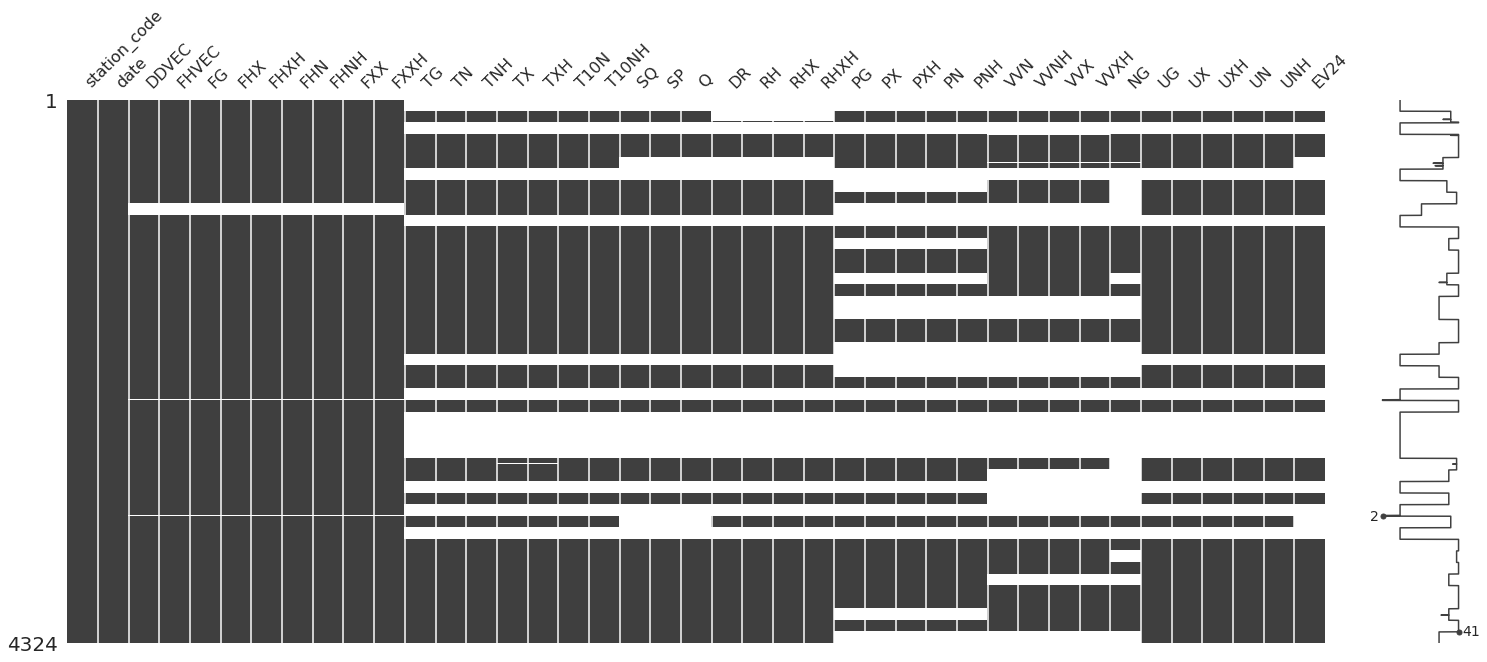

In [250]:
#Select specific range by subsetting saved weather dataset for full range
#Stable range_1: Relatively flat/many zero values - Nov 2020 to July 2021(end of June) 8 months
#Stable range_2: Stable/less zeroes - July 2020 - Oct 2020(end of Sept) 3 months

with open('/content/gdrive/My Drive/Colab Notebooks/Orbisk_assg/weather_data.csv', 'rb') as f:
  weather_data = pd.read_csv(f)

weather_data['date'] = pd.to_datetime(weather_data['date'])
weather_data['date'] = weather_data['date'].apply(lambda x : x.date()) #strip time from the datetime object. 
weather_data['date'] = pd.to_datetime(weather_data['date']) #convert back to datetime
# weather_data['date'][0]


#------------enter date range here----------
start_date = "2020-07-01" #yyyy-mm-dd
end_date = "2020-09-30"
#------------enter date range here----------


after_start_date = weather_data["date"] >= start_date
before_end_date = weather_data["date"] <= end_date
between_two_dates = after_start_date & before_end_date
weather_data_small = weather_data.loc[between_two_dates]

len(weather_data_small) #4324 for range_2
##Check missing values:
msno.matrix(weather_data_small) 

In [251]:
len(weather_data_small) 

4324

In [252]:

#----------
#Prepare dataframe to merge. Take mean from stations so that 1 row for each date.
we_dt_mean=weather_data_small.groupby('date').mean() 
we_dt_mean = we_dt_mean.drop('station_code', 1) #drop station code which has no meaning now
we_dt_mean.reset_index(inplace=True)
we_dt_mean.head()


we_dt_mean.dtypes #Check initial datatype
we_dt_mean['date'] = pd.to_datetime(we_dt_mean['date'])
we_dt_mean['date'][0] #check the value
we_dt_mean['date'][0].year #test if parsed correctly. try with month, and day as well


we_dt_mean['date'] = we_dt_mean['date'].apply(lambda x : x.date()) #strip time from the datetime object
print(we_dt_mean['date'][0]) #to check if the format is correct
we_dt_mean['date'] = pd.to_datetime(we_dt_mean['date']) #Convert again to datetime object
we_dt_mean.dtypes[0:2] #datetime object created


2020-07-01


date     datetime64[ns]
DDVEC           float64
dtype: object

In [253]:
len(we_dt_mean) #242
len(client_data_ts_res) #592

592

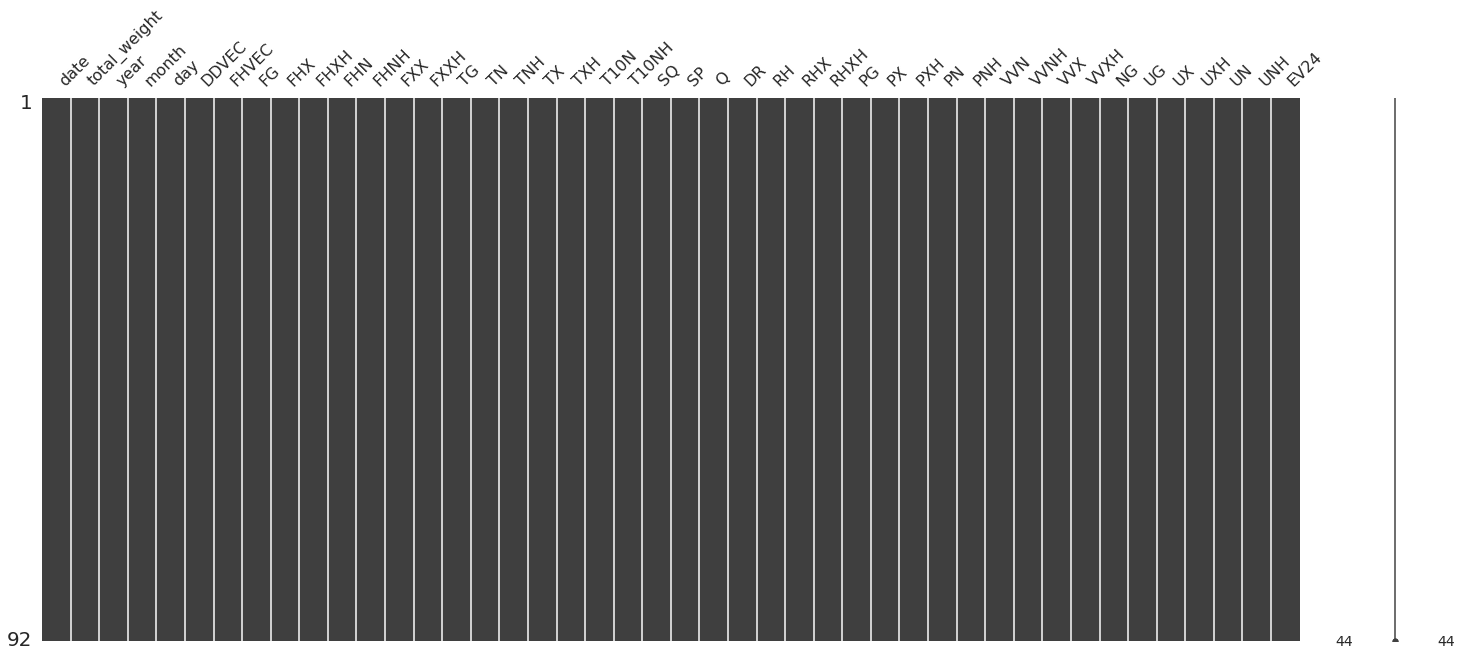

In [254]:
#join 
cl_wea_df_small = pd.merge(client_data_ts_res, we_dt_mean, on='date',how='inner')  #include only rows of date which have a corresponding waste value
cl_wea_df_small
msno.matrix(cl_wea_df_small) #Date range was only 2 months.

In [255]:
corr_mat = cl_wea_df_small.corr()
print (corr_mat)

              total_weight  year     DDVEC  ...        UN       UNH      EV24
total_weight      1.000000   NaN -0.242946  ... -0.127189 -0.023788 -0.108961
year                   NaN   NaN       NaN  ...       NaN       NaN       NaN
DDVEC            -0.242946   NaN  1.000000  ...  0.402237 -0.035836 -0.169082
FHVEC             0.093358   NaN  0.126376  ...  0.323425 -0.112969 -0.329112
FG                0.098535   NaN  0.155548  ...  0.353231 -0.101363 -0.354935
FHX               0.062683   NaN  0.145609  ...  0.369328 -0.030027 -0.395366
FHXH             -0.118162   NaN -0.087329  ... -0.145110  0.226529  0.114605
FHN               0.104978   NaN  0.066647  ...  0.271506 -0.157474 -0.276906
FHNH              0.104270   NaN  0.249789  ...  0.185342 -0.059353 -0.164140
FXX               0.020404   NaN  0.139674  ...  0.360585 -0.024152 -0.378296
FXXH             -0.140192   NaN -0.115222  ... -0.133098  0.220495  0.091561
TG                0.046396   NaN -0.460896  ... -0.446440  0.144

Below is for range_1-8 months which was stable but had many 0 values. range_2-3 months is stable and has less 0 values but smaller date range, gives different results.
We can confirm that still the best factors which seem to be linearly correlated are as before but with stronger correlation values. Select the ones which have a magnitud of correlation:
*  Greater than 0.4
  * TG 0.46: 24- hour average temperature (in 0.1 degrees Celsius)
  * TX 0.43: Maximum temperature (in 0.1 degrees Celsius)
  * TN 0.46: Minimum temperature (in 0.1 degrees Celsius)
  * T10N 0.45: Minimum temperature at 10 cm height (in 0.1 degrees Celsius)

*  Greater than 0.3
  * EV24 0.39 : Reference crop evaporation (Makkink) (in 0.1 mm)
  * Q 0.35 : Global radiation (in J/cm2)

*  Greater than 0.2
  * RHX 0.26 : Highest hourly sum of precipitation (in 0.1 mm) 
  * year 0.24 : 2019,2020,2021

It appears that food waste quantity is correlated with temperature measures.
All these are positively correlated. The higher the temperture, more seems to be the waste.
- Maybe because they get spoilt and have to be thrown?





### Linear regression for small range all columns

In [256]:
# Create a Linear regression model for forecasting based on temperature.
cl_wea_df_small.head()


,date,total_weight,year,month,day,DDVEC,FHVEC,FG,FHX,FHXH,FHN,FHNH,FXX,FXXH,TG,TN,TNH,TX,TXH,T10N,T10NH,SQ,SP,Q,DR,RH,RHX,RHXH,PG,PX,PXH,PN,PNH,VVN,VVNH,VVX,VVXH,NG,UG,UX,UXH,UN,UNH,EV24
0,2020-07-01,15178,2020,Jul,Wed,237.500000,57.717391,60.130435,87.173913,13.130435,36.086957,6.152174,133.478261,13.500000,175.147059,143.852941,16.617647,209.794118,13.823529,133.205882,19.235294,47.96875,28.68750,1584.84375,41.53125,82.46875,26.78125,7.15625,10061.250000,10081.083333,23.125000,10048.333333,6.583333,46.16,8.56,80.36,15.00,7.35,83.411765,96.441176,2.470588,64.529412,15.352941,27.62500
1,2020-07-02,17829,2020,Jul,Thu,249.195652,50.456522,53.956522,78.913043,12.630435,28.695652,12.108696,122.391304,12.847826,166.941176,132.500000,17.029412,205.970588,13.147059,120.029412,18.176471,60.46875,36.28125,1852.09375,5.96875,20.84375,18.12500,10.46875,10108.708333,10144.208333,23.791667,10081.125000,1.541667,60.76,10.40,81.28,13.36,6.25,79.294118,93.235294,13.941176,60.411765,14.647059,31.75000
2,2020-07-03,20962,2020,Jul,Fri,233.586957,66.869565,68.869565,103.260870,14.978261,26.304348,1.847826,156.304348,16.260870,170.647059,125.294118,2.735294,211.411765,13.941176,114.235294,6.000000,62.21875,37.40625,1908.40625,0.21875,-0.21875,-0.21875,2.62500,10156.000000,10165.166667,10.583333,10141.750000,10.750000,52.36,6.68,81.76,14.68,7.25,74.205882,94.205882,3.352941,55.529412,14.911765,32.84375
3,2020-07-04,20136,2020,Jul,Sat,221.500000,87.434783,88.239130,104.347826,10.347826,72.826087,8.500000,165.869565,12.521739,168.941176,144.352941,3.705882,186.058824,16.117647,141.705882,6.176471,1.81250,1.12500,647.75000,84.25000,60.96875,14.81250,15.65625,10121.291667,10143.541667,1.083333,10100.166667,22.625000,32.72,15.00,73.12,3.72,8.00,88.823529,96.500000,16.352941,75.941176,3.147059,11.12500
4,2020-07-05,28755,2020,Jul,Sun,237.500000,96.782609,98.978261,123.913043,10.521739,71.739130,14.847826,192.608696,12.152174,179.176471,142.852941,23.088235,215.529412,14.852941,136.382353,24.000000,50.43750,30.40625,1495.31250,15.59375,10.90625,5.68750,9.50000,10095.416667,10107.666667,21.916667,10083.458333,6.458333,43.24,7.96,80.44,15.72,6.90,79.029412,94.352941,4.617647,59.117647,17.588235,26.15625


In [257]:
#Regression with small range and all numerical columns 

x = cl_wea_df_small.drop(['total_weight','date','month','day','year'], axis =1).values
y = cl_wea_df_small['total_weight'].values 

#Train test split
from sklearn.model_selection import train_test_split 
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size= 0.3, random_state = 0)

#fit model
from sklearn.linear_model import LinearRegression
ml = LinearRegression()
ml.fit(x_train, y_train)

#Make predictions
y_pred = ml.predict(x_test)
# print(y_pred)

# #Model Evaluation
from sklearn.metrics import explained_variance_score, r2_score # r^2 <- explained_variance_score  r2_score <-  adjusted r2
print("Adjusted R2 is: ",r2_score(y_test,y_pred)) # 0.16
print("R2 is: ",explained_variance_score(y_test,y_pred)) #0.17


Adjusted R2 is:  -2.3044508698336403
R2 is:  -2.1085922946619764


Text(0.5, 1.0, 'Actual Vs Predicted')

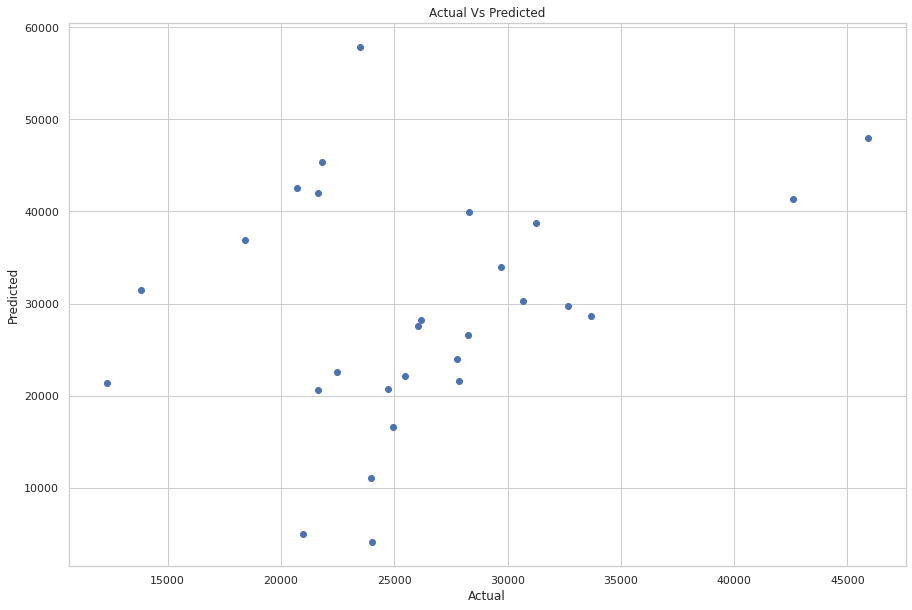

In [258]:
# Plot scatter
plt.figure(figsize=(15,10))
plt.scatter(y_test, y_pred)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual Vs Predicted')

In [259]:
print("Length with full data: ",len(cl_wea_df))
print("Length with small range: ",len(cl_wea_df_small))

Length with full data:  592
Length with small range:  92


### Linear Regression with full range all columns

In [260]:
# Regression with full range and all columns 
x = cl_wea_df.drop(['total_weight','date','month','day','year'], axis =1).values
y = cl_wea_df['total_weight'].values 

#Train test split
from sklearn.model_selection import train_test_split 
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size= 0.3, random_state = 0)

#fit model
from sklearn.linear_model import LinearRegression
ml = LinearRegression()
ml.fit(x_train, y_train)

#Make predictions
y_pred = ml.predict(x_test)
# print(y_pred)

# #Model Evaluation
from sklearn.metrics import explained_variance_score, r2_score # r^2 <- explained_variance_score  r2_score <-  adjusted r2
print("Adjusted R2 is: ",r2_score(y_test,y_pred)) # 0.16
print("R2 is: ",explained_variance_score(y_test,y_pred)) #0.03

Adjusted R2 is:  0.04263623304964881
R2 is:  0.04675450822920968


Text(0.5, 1.0, 'Actual Vs Predicted')

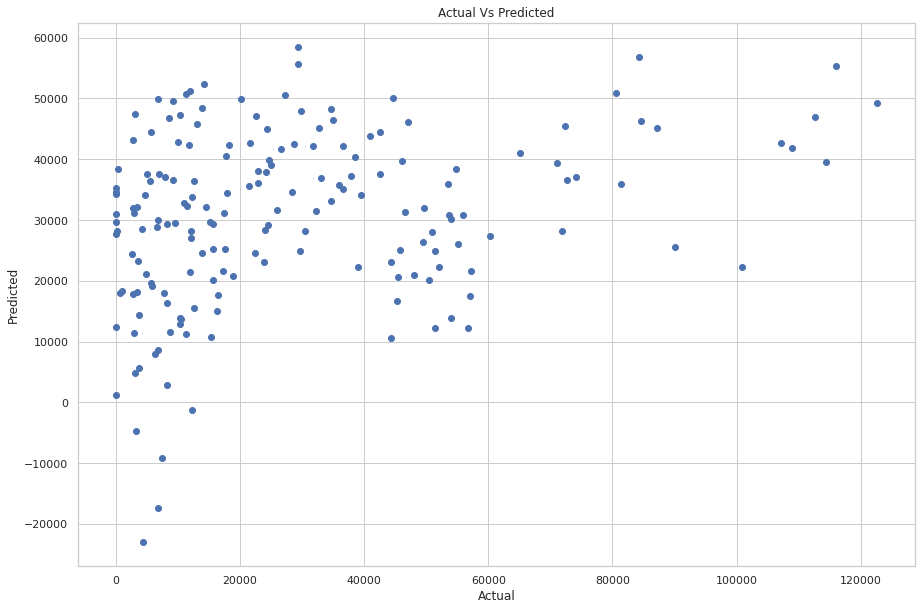

In [261]:
# Plot scatter
plt.figure(figsize=(15,10))
plt.scatter(y_test, y_pred)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual Vs Predicted')

### LR small range and selected columns

In [262]:
# Regression with small range and selected columns >0.4
x=cl_wea_df_small[['TG','TX','TN','T10N']].values
y = cl_wea_df_small['total_weight'].values 

#Train test split
from sklearn.model_selection import train_test_split 
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size= 0.3, random_state = 0)

#fit model
from sklearn.linear_model import LinearRegression
ml = LinearRegression()
ml.fit(x_train, y_train)

#Make predictions
y_pred = ml.predict(x_test)
# print(y_pred)

# #Model Evaluation
from sklearn.metrics import explained_variance_score, r2_score # r^2 <- explained_variance_score  r2_score <-  adjusted r2
print("Adjusted R2 is: ",r2_score(y_test,y_pred)) # 0.16
print("R2 is: ",explained_variance_score(y_test,y_pred)) #0.17


Adjusted R2 is:  0.05732831000145111
R2 is:  0.0699984201137338


Text(0.5, 1.0, 'Actual Vs Predicted')

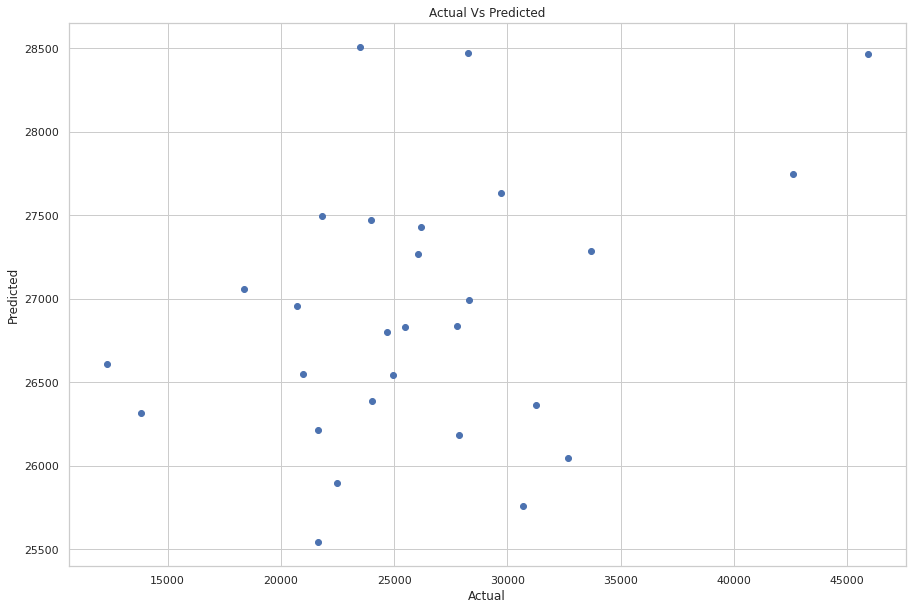

In [263]:
# Plot scatter
plt.figure(figsize=(15,10))
plt.scatter(y_test, y_pred)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual Vs Predicted')

### LR full range and selected columns

In [264]:
# Regression with full range and selected columns >0.2 for full dataset
x=cl_wea_df[['TG','TX','TN','T10N']].values
y = cl_wea_df['total_weight'].values 

#Train test split
from sklearn.model_selection import train_test_split 
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size= 0.3, random_state = 0)

#fit model
from sklearn.linear_model import LinearRegression
ml = LinearRegression()
ml.fit(x_train, y_train)

#Make predictions
y_pred = ml.predict(x_test)
# print(y_pred)

# #Model Evaluation
from sklearn.metrics import explained_variance_score, r2_score # r^2 <- explained_variance_score  r2_score <-  adjusted r2
print("Adjusted R2 is: ",r2_score(y_test,y_pred)) # 0.16
print("R2 is: ",explained_variance_score(y_test,y_pred)) #0.03


Adjusted R2 is:  0.016286866318276583
R2 is:  0.03788259708353159


Text(0.5, 1.0, 'Actual Vs Predicted')

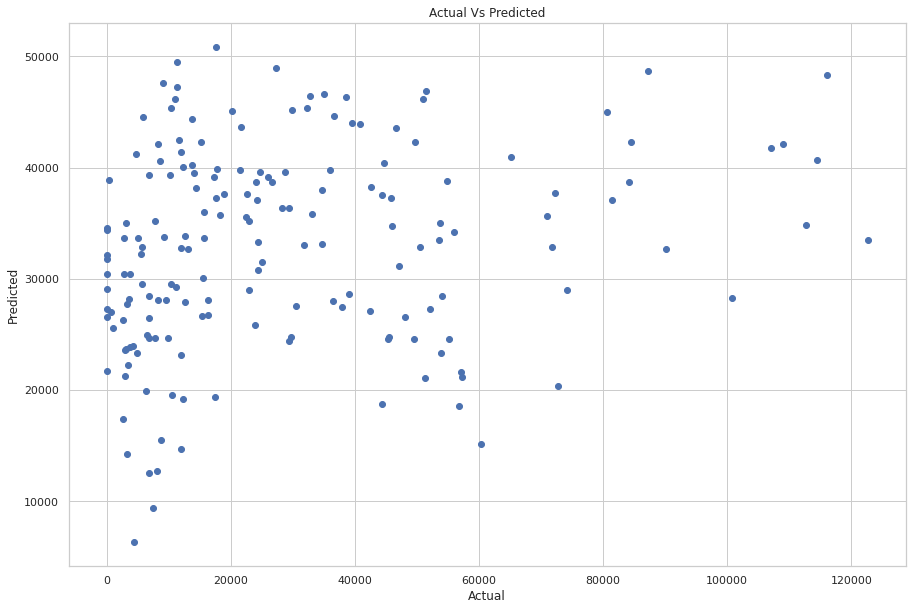

In [265]:
# Plot scatter
plt.figure(figsize=(15,10))
plt.scatter(y_test, y_pred)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual Vs Predicted')

Considering only the 4 cols with highest correlation, we note:
  - Model seems to be overestimating prediction till about 600T. 
  - If all features are used model overfits.

## Additional code commented out

In [ ]:
## Create figure and plot space. Edit: Use line plot instead for trend
# fig, ax = plt.subplots(figsize=(20, 6))
# ax.bar(client_data_ts_res.index.values,
#         client_data_ts_res['total_weight'],
#         # color='purple',
#         )
# ax.set(xlabel="Date",
#        ylabel="Total weight",
#        title="High level distribution of data")
# plt.setp(ax.get_xticklabels(), rotation=45)
# plt.show()

In [ ]:
# client_data.date.sort_values().unique()
# client_data['day'] = client_data['date'].apply(lambda x: x.strftime("%a")) #day name


In [ ]:
# fig, axes = plt.subplots(2,1, figsize=(18, 10))
# sns.barplot(ax=axes[0] ,x="month", y="total_weight", hue="day", data=client_data[client_data['year']==2019], ci = False)
# sns.barplot(ax=axes[1],x="month", y="total_weight", hue="day", data=client_data[client_data['year']==2020], ci = False)

In [ ]:
#Compare heatmap for full weather dataset and smaller weather dataset 
#Make heatmap for correlations
# fig, ax = plt.subplots(figsize=(5, 5))
# corr = cl_wea_df.corr()
# ax = sns.heatmap(
#     corr, 
#     vmin=-1, vmax=1, center=0,
#     cmap=sns.diverging_palette(20, 220, n=200),
#     square=True
# )
# ax.set_xticklabels(
#     ax.get_xticklabels(),
#     rotation=45,
#     horizontalalignment='right'
# );

#Make heatmap for correlations
# fig, ax = plt.subplots(figsize=(5, 5))
# corr = cl_wea_df_small.corr()
# ax = sns.heatmap(
#     corr, 
#     vmin=-1, vmax=1, center=0,
#     cmap=sns.diverging_palette(20, 220, n=200),
#     square=True
# )
# ax.set_xticklabels(
#     ax.get_xticklabels(),
#     rotation=45,
#     horizontalalignment='right'
# );